## Notebook 4: Exploring the "Description" variable.

### Project Goal: 

This project uses a Kaggle database of over 129,000 wine reviews from Wine Enthusiast/Wine Magazine. The data contains information related to variety, price, rating, and tasting notes. My desired outcome is to create a wine recommender that, when a user inputs a wine name, it will recommend a similar wine. The similarity will be based on variety, tasting notes, and price.

### What's in This Notebook

In this notebook, I begin examining the Description variable. My goal with this work is just to understand more what type of words may be used to describe specific varietals. 

KMeans Clustering. I used KMeans clustering on a sample of the descriptions (n=20000) and set it to 20 clusters to see whether the clusters seemed to match the 20 varietals in the dataset. The results were mixed, although some varietals are clearly identified by specific clusters. 

Next, I try out clustering to find just Red or White wine. It appears Red wine is easier to identify through the descriptions compared to white. 

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image
#from IPython.display import Image
from os import path
from sklearn.cluster import KMeans

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.metrics.pairwise import linear_kernel

plt.style.use('fivethirtyeight')
%matplotlib inline

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score

In [11]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 999)

In [12]:
df = pd.read_csv('./datasets/wine.csv', index_col=0)

In [13]:
df.shape

(73691, 14)

### KMeans Clustering on a Sample of the Descriptions

In [29]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

In [31]:
my_additional_stop_words = ['wine', 'flavor', 'flavors', 'notes', 'offers', 'enjoy', 'drink', 'bottling',
                           'really', 'reveal', 'picked', 'partner', 'thanks', 'grown', 'gain', 
                           'thanks', 'percentage', 'buy', 'mid', 'gain', 'bottle', 'amid', 'available',
                           'come', 'aspect', 'try', 'pinot', 'noir', 'chardonnay','cabernet', 'sauvignon',
                            'red','white','bordeaux', 'riesling', 'blanc','syrah','merlot',
                            'rose', 'zinfandel','malbec','nebbiolo','sangiovese', 'tempranillo','sparkling',
                            'rhone','gris', 'riesling', 'sirah', 'petite', 'petit', 'make']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [34]:
from random import sample
sample = df.sample(20000, random_state = 42)
sample_desc = sample['description']

In [55]:
sample['variety'].value_counts(); #still all 20 varietals represented

In [36]:
tf_vect = TfidfVectorizer(stop_words = stop_words, tokenizer=tokenize, max_features = 2000)
X_sample = tf_vect.fit_transform(sample_desc)
words_sample = tf_vect.get_feature_names()

In [37]:
kmeans = KMeans(n_clusters = 20, n_init = 5, n_jobs = -1)
kmeans.fit(X_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [38]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_sample[word] for word in centroid))

0 : palat, tannin, alongsid, black, cherri, aroma, offer, berri, licoric, firm, spice, pepper, open, note, whiff
1 : wood, age, fruit, rich, ripe, tannin, black, acid, structur, year, balanc, spice, firm, charact, juici
2 : fruiti, attract, readi, soft, fruit, ripe, acid, tannin, light, juici, fresh, aftertast, berri, charact, round
3 : oak, new, french, age, barrel, fruit, month, american, ferment, cherri, year, spent, toast, vineyard, note
4 : pineappl, butter, toast, vanilla, acid, sweet, oak, rich, peach, mango, fruit, ripe, orang, crisp, tropic
5 : citrus, fruit, finish, peach, tropic, palat, aroma, melon, fresh, note, acid, nose, pear, stone, clean
6 : appl, pear, green, palat, finish, fresh, lemon, aroma, acid, nose, note, fruit, light, citrus, peach
7 : crisp, acid, fruiti, textur, fresh, bright, charact, fruit, light, miner, aftertast, tight, live, citrus, tangi
8 : herb, aroma, fruit, spice, barrel, follow, lead, bring, cherri, dark, vanilla, note, appeal, coffe, tannin
9 : s

In [39]:
sample['cluster'] = kmeans.labels_

### Heatmap

This heatmap compares the clusters that KMeans identified versus the actual varietals. It's not perfect, but some varietals do come out prominently in specific cluters. Pinot Noir is present in cluster 13, Chardonnay in clusters 4-6, Riesling in cluster 10, Cabernet in 11.Some clusters capture several varietals. Cluster 0 gets at Nebiollo, Red Blends and Sangiovese. 

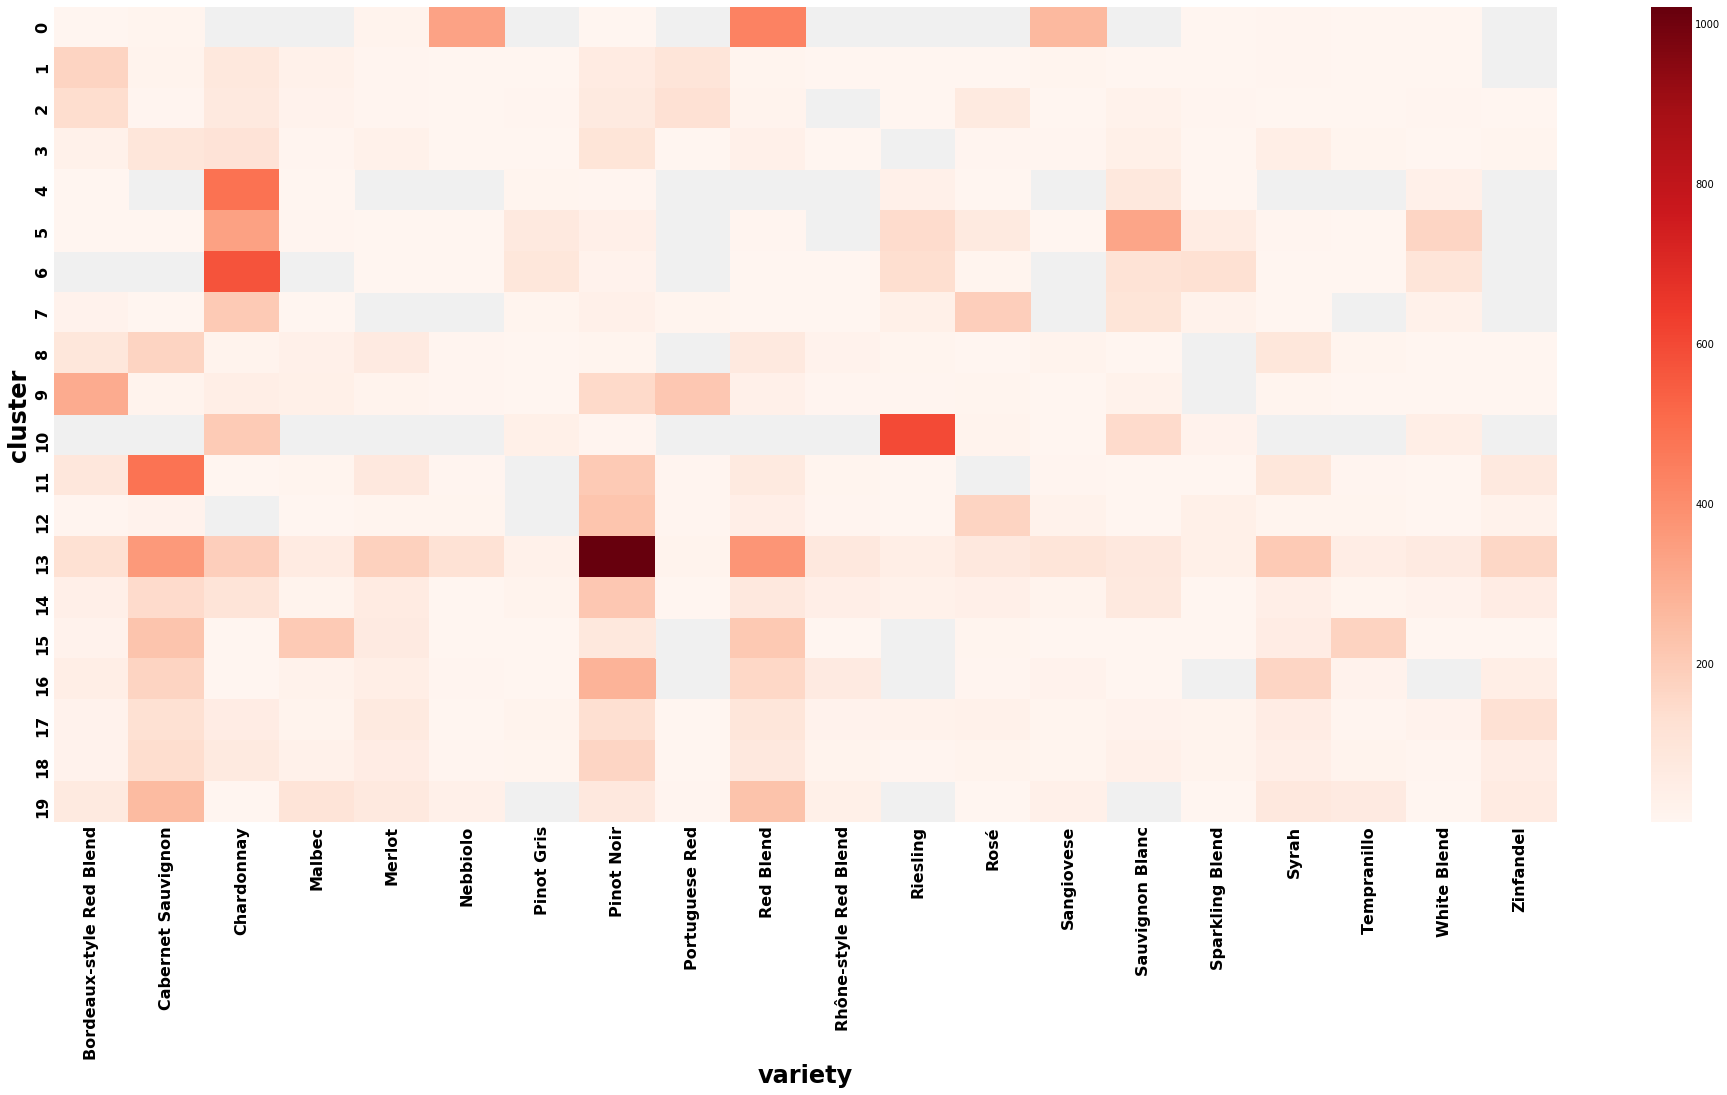

In [40]:
clusters = sample.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

### Examining Descriptions for Red and White

The descriptions may not be great at identifying specific varietals, but perhaps they will fare better at identifying whether a wine is simply Red or White. In this section, I create a variable to identify whether the wine is Red or White, and do another Kmeans this time with two clusters. 

Common words in cluster zero (looks like white): apple, acid, fruit, finish, crisp, fresh, citrus, lemon, peach, light, palate, pear, miner, lime.

Common words in cluster one (looks like red): cherries, fruit, tannin, black, aroma, berries, finish, spice, palate, blackberries, ripe, plum. 

Comparing the clusters to the reality shows that the descriptions appear to be very good at identifying Red wine, but not so much with the white wine. 

In [41]:
RW_dict = {'Pinot Noir': 'Red', 
                  'Cabernet Sauvignon': 'Red', 
                  'Red Blend': 'Red',
                  'Bordeaux-style Red Blend':'Red',
                  'Syrah': 'Red', 
                  'Merlot':'Red', 
                  'Zinfandel':'Red', 
                  'Malbec': 'Red', 
                  'Nebbiolo': 'Red', 
                  'Sangiovese': 'Red',
                  'Portuguese Red': 'Red', 
                  'Tempranillo': 'Red', 
                  'Rhône-style Red Blend': 'Red', 
                  'Chardonnay': 'White', 
                  'Riesling':'White', 
                  'Sauvignon Blanc': 'White', 
                  'Rosé': 'White', 
                  'White Blend': 'White', 
                  'Sparkling Blend': 'White', 
                  'Pinot Gris': 'White'}

df['red_or_white']= df['variety'].map(RW_dict)

In [43]:
df['red_or_white'].value_counts()

Red      49452
White    24239
Name: red_or_white, dtype: int64

In [44]:
sample2 = df.sample(n=20000)

In [45]:
sample2['red_or_white'].value_counts() 

Red      13471
White     6529
Name: red_or_white, dtype: int64

In [46]:
sample2_desc = sample['description']

In [47]:
tf_vect = TfidfVectorizer(stop_words = stop_words, tokenizer=tokenize, max_features = 2000, ngram_range = (1,2))
X2_sample = tf_vect.fit_transform(sample2_desc)
words_sample2 = tf_vect.get_feature_names()

In [48]:
kmeans = KMeans(n_clusters = 2, n_init = 5, n_jobs = -1)
kmeans.fit(X2_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [53]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-31:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_sample2[word] for word in centroid))

0 : appl, acid, fruit, finish, crisp, fresh, citrus, lemon, peach, light, palat, pear, miner, lime, ripe, dri, textur, sweet, aroma, note, pineappl, fruiti, rich, green, nose, orang, honey, balanc, bright, tropic
1 : cherri, fruit, tannin, black, aroma, berri, finish, spice, palat, blackberri, ripe, plum, dri, oak, acid, rich, note, dark, blend, raspberri, soft, structur, age, firm, chocol, currant, herb, offer, bodi, year


In [50]:
sample2['cluster'] = kmeans.labels_

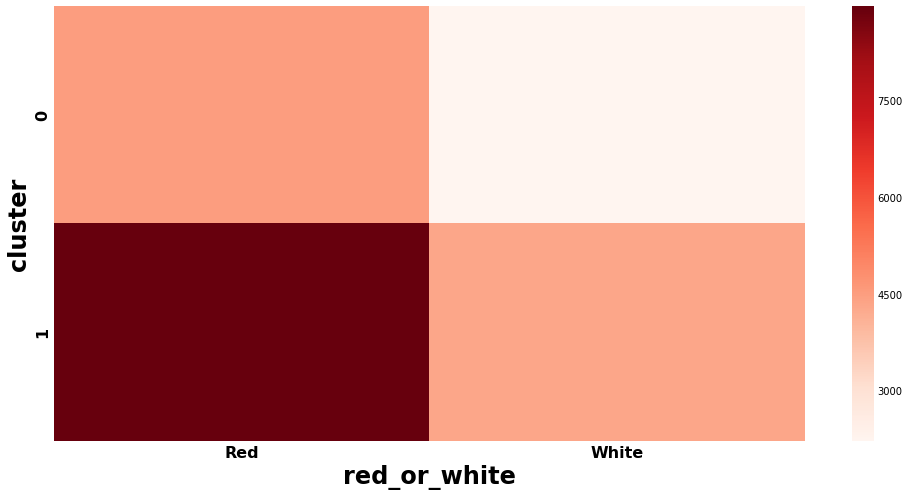

In [51]:
clusters = sample2.groupby(['cluster', 'red_or_white']).size()
fig2, ax2 = plt.subplots(figsize = (15, 8))
sns.heatmap(clusters.unstack(level = 'red_or_white'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('red_or_white', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")